# 1. data import & preprocessing 

In [37]:
import numpy as np
import pandas as pd

* dataset 불러오기

In [38]:
data25 = pd.read_csv("C:/Users/ishon/OneDrive/바탕 화면/compas/model/data/feature25.csv")
data50 = pd.read_csv("C:/Users/ishon/OneDrive/바탕 화면/compas/model/data/feature50.csv")

data25['is_bump20'] = data25['shortest_bump_dist'] < 20
data50['is_bump40'] = data50['shortest_bump_dist'] < 40

data25['is_sidewalk12.5'] = data25['shortest_sidewalk_dist'] < 12.5
data50['is_sidewalk25'] = data50['shortest_sidewalk_dist'] < 25

data25['is_cross100'] = data25['shortest_cross_dist'] < 100
data50['is_cross100'] = data50['shortest_cross_dist'] < 100

data25['is_signal150'] = data25['shortest_traffic_signal_dist'] < 150
data50['is_signal150'] = data50['shortest_traffic_signal_dist'] < 150

In [39]:
col = {"x_common": ['overspeed_cam_count100', 'floating_pop_count50','car_count1000', 'child_count1000', 
                  'elem_kinder_count400','num_cram_school_count400', 
                  'shortest_cross_dist','shortest_traffic_signal_dist',], # 'numberSchoolZone_count400'
       "x_25" : ['is_bump20', 'parking_count12.5','is_sidewalk12.5', 'barrier_nearby_count12.5',
                   'chaos1_nearby_count12.5', 'width_nearby_count12.5','cross_road_nearby_count12.5',
                   ],
       "x_50" : ['is_bump40', 'parking_count25','is_sidewalk25', 'barrier_nearby_count25',
                   'chaos1_nearby_count25', 'width_nearby_count25','cross_road_nearby_count25'],
       "y_25" : 'accident_count12.5',
       "y_50" : 'accident_count25',}

xy25 = data25[col1["x_common"] + col1["x_25"] +[col1['y_25']]].astype(float)
xy50 = data50[col1["x_common"] + col1["x_50"] +[col1['y_50']]].astype(float)
xy25[col1['y_25']] = (xy25[col1['y_25']] > 0).astype(float)
xy50[col1['y_50']] = (xy50[col1['y_50']] > 0).astype(float)

In [40]:
protection = ["barrier_nearby_count12.5", "barrier_nearby_count25", "shortest_cross_dist",
             "overspeed_cam_count100",  "shortest_traffic_signal_dist","is_bump40","is_bump20", 
              "is_sidewalk12.5", "is_sidewalk25",]
p_value = ["car_count1000", "child_count1000", "chaos1_nearby_count12.5", "chaos1_nearby_count25"]
del_col = protection + p_value

xy25 = data25[col["x_common"] + col["x_25"] +[col['y_25']]].astype(float)
xy50 = data50[col["x_common"] + col["x_50"] +[col['y_50']]].astype(float)
xy25[col['y_25']] = (xy25[col['y_25']] > 0).astype(float)
xy50[col['y_50']] = (xy50[col['y_50']] > 0).astype(float)

x50, y50 = xy50.iloc[:,:-1], xy50.iloc[:,-1]
x25, y25 = xy25.iloc[:,:-1], xy25.iloc[:,-1]
x50 = x50.loc[:,~np.isin(x50.columns,del_col)]
x25 = x25.loc[:,~np.isin(x25.columns,del_col)]

In [41]:
xy50=pd.concat([x50, y50], axis=1)
xy25=pd.concat([x25, y25], axis=1)

* cluster data 불러오기

In [42]:
kmeans25 = pd.read_csv("C:/Users/ishon/OneDrive/바탕 화면/compas/model/data/kmeans_cluster25.csv")
kmeans50 = pd.read_csv("C:/Users/ishon/OneDrive/바탕 화면/compas/model/data/kmeans_cluster50.csv")

In [43]:
print(xy25.shape)
print(kmeans25.shape)
print(xy50.shape)
print(kmeans50.shape)

(7636, 7)
(7636, 1)
(3912, 7)
(3912, 1)


* dataset 합치기

In [44]:
xy25=pd.concat([xy25, kmeans25], axis=1)
xy25.rename(columns={'0':'cluster'}, inplace=True)

xy50=pd.concat([xy50, kmeans50], axis=1)
xy50.rename(columns={'0':'cluster'}, inplace=True)

* 열 이름 통일

In [45]:
xy25.columns

Index(['floating_pop_count50', 'elem_kinder_count400',
       'num_cram_school_count400', 'parking_count12.5',
       'width_nearby_count12.5', 'cross_road_nearby_count12.5',
       'accident_count12.5', 'cluster'],
      dtype='object')

In [46]:
xy50.rename(columns={'parking_count25':'parking_count', 'width_nearby_count25':'width_nearby_count', 
                     'cross_road_nearby_count25':'cross_road_nearby_count', 'accident_count25':'accident_count'},inplace=True)
xy25.rename(columns={'parking_count12.5':'parking_count', 'width_nearby_count12.5':'width_nearby_count', 
                     'cross_road_nearby_count12.5':'cross_road_nearby_count', 'accident_count12.5':'accident_count'},inplace=True)

* train-test split

In [47]:
X_train=xy50.drop(['accident_count'], axis=1)
y_train=xy50['accident_count']

X_test=xy25.drop(['accident_count'], axis=1)
y_test=xy25['accident_count']

# 2. Modeling

### 2-1) XGB Classifier

In [48]:
from xgboost import plot_importance
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, make_scorer, confusion_matrix, accuracy_score, precision_score, recall_score, roc_auc_score

In [51]:
f1 = make_scorer(f1_score)

In [52]:
xgb=XGBClassifier(scale_pos_weight=y_train.value_counts()[0]/y_train.value_counts()[1])

xgb_param_grid={
    'n_estimators':[500, 1000],
    'max_depth':[5, 7, 10],
    'learning_rate':[0.01, 0.1],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.5, 0.7],
    'colsample_bytree': [0.5, 0.7]
}

xgb_grid = GridSearchCV(xgb, param_grid=xgb_param_grid, scoring=f1, cv=3, n_jobs=-1, verbose=3)
xgb_grid.fit(X_train, y_train)

Fitting 3 folds for each of 144 candidates, totalling 432 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   21.6s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 432 out of 432 | elapsed:  6.7min finished
C:\Users\ishon\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:44:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs...
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=15.646808510638298,
                                     subsample=None, tree_method=None,
                                     validate_parameters=None, verbo

In [53]:
print('best score : {0:.4f}'.format(xgb_grid.best_score_))
print('best param : ', xgb_grid.best_params_)

best score : 0.2222
best param :  {'colsample_bytree': 0.5, 'learning_rate': 0.01, 'max_depth': 5, 'min_child_weight': 5, 'n_estimators': 500, 'subsample': 0.7}


In [54]:
xgb_model = xgb_grid.best_estimator_
xgb_pred = xgb_model.predict(X_test)

In [55]:
f1_score(y_test, xgb_pred, average=None)

array([0.89306038, 0.16886847])

### feature importance

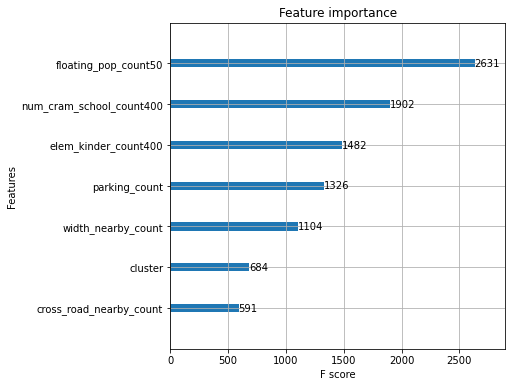

In [56]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(6, 6))
plot_importance(xgb_model, ax=ax)

### 2-2) LGBM Classifier

In [57]:
from lightgbm import LGBMClassifier
from lightgbm import plot_importance

* cluster를 categorical type으로 변환

In [59]:
X_train['cluster']=X_train['cluster'].astype('category')
X_test['cluster']=X_test['cluster'].astype('category')

In [60]:
lgb = LGBMClassifier(categorical_feature='name:cluster', scale_pos_weight=y_train.value_counts()[0]/y_train.value_counts()[1])

lgb_param_grid={
    'learning_rate':[0.01, 0.1],
    'n_estimators':[500,1000],
    'max_depth':[3,7,10],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.5, 0.7],
    'colsample_bytree': [0.5, 0.7]
}

lgb_grid = GridSearchCV(lgb, param_grid=lgb_param_grid, scoring=f1, cv=3, n_jobs=-1, verbose=3)
lgb_grid.fit(X_train, y_train)

Fitting 3 folds for each of 144 candidates, totalling 432 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 432 out of 432 | elapsed:  3.8min finished
C:\Users\ishon\anaconda3\lib\site-packages\lightgbm\basic.py:1075: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  warnings.warn('{0} keyword has been found in `params` and will be ignored.\n'
C:\Users\ishon\anaconda3\lib\site-packages\lightgbm\basic.py:1098: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


GridSearchCV(cv=3,
             estimator=LGBMClassifier(categorical_feature='name:cluster',
                                      scale_pos_weight=15.646808510638298),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.5, 0.7],
                         'learning_rate': [0.01, 0.1], 'max_depth': [3, 7, 10],
                         'min_child_weight': [1, 3, 5],
                         'n_estimators': [500, 1000], 'subsample': [0.5, 0.7]},
             scoring=make_scorer(f1_score, average=binary), verbose=3)

In [61]:
print('best score : {0:.4f}'.format(lgb_grid.best_score_))
print('best param : ', lgb_grid.best_params_)

best score : 0.2405
best param :  {'colsample_bytree': 0.5, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 500, 'subsample': 0.5}


In [62]:
lgb_model = lgb_grid.best_estimator_
lgb_pred = lgb_model.predict(X_test)

In [63]:
f1_score(y_test, lgb_pred, average=None)

array([0.84795322, 0.13181019])

### feature importance

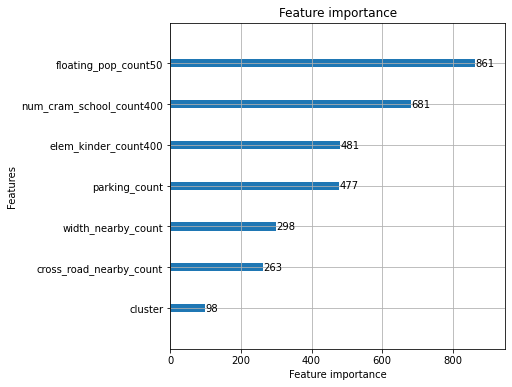

In [64]:
f, ax=plt.subplots(figsize=(6,6))
plot_importance(lgb_model, max_num_features=15, ax=ax) 

## f1 score 비교

In [80]:
print('best score : {0:.4f}'.format(xgb_grid.best_score_))
print(f1_score(y_test, xgb_pred, average=None))

print('best score : {0:.4f}'.format(lgb_grid.best_score_))
print(f1_score(y_test, lgb_pred, average=None))

best score : 0.2222
[0.89306038 0.16886847]
best score : 0.2405
[0.84795322 0.13181019]


In [81]:
confusion_matrix(y_test, xgb_pred)

array([[6042, 1399],
       [  48,  147]], dtype=int64)

In [82]:
confusion_matrix(y_test, lgb_pred)

array([[5510, 1931],
       [  45,  150]], dtype=int64)

### cut-off 조정

In [84]:
X_test_xgb=X_test.drop(['cluster'], axis=1)

In [97]:
xgb_pred2 = (xgb_model.predict_proba(X_test_xgb)[:,1]>=0.7).astype(int)
print('f1 score:', f1_score(y_test, xgb_pred2))

confusion_matrix(y_test, xgb_pred2)

f1 score: 0.20609579100145137


array([[7018,  423],
       [ 124,   71]], dtype=int64)

In [100]:
lgb_pred2 = (lgb_model.predict_proba(X_test)[:,1]>=0.7).astype(int)
print('f1 score:', f1_score(y_test, lgb_pred2))

confusion_matrix(y_test, lgb_pred2)

f1 score: 0.17789072426937735


array([[6919,  522],
       [ 125,   70]], dtype=int64)

## 위험구역 from xgb

In [66]:
X_test_xgb=X_test.drop(['cluster'], axis=1)

In [69]:
xgb_pred_prob = xgb_model.predict_proba(X_test_xgb)

danger_xgb=pd.DataFrame(xgb_pred_prob)
danger_xgb.columns=['No_xgb', 'Yes_xgb']

In [70]:
danger_xgb=pd.concat([data25, danger_xgb], axis=1)
danger_xgb_all=danger_xgb.sort_values(by=['Yes_xgb'], ascending=False)[0:40] #그냥 상위 40개

In [71]:
danger_xgb_without=danger_xgb[danger_xgb['overspeed_cam_count100']==0]
danger_xgb_without=danger_xgb_without.sort_values(by=['Yes_xgb'], ascending=False)[0:40] #카메라 없는 곳 상위 40개

In [72]:
import geopandas as gpd
import json
import folium
from folium import plugins

In [73]:
osan=gpd.read_file("C:/Users/ishon/OneDrive/바탕 화면/SIG_202005/SIG.shp")
osan=osan[osan["SIG_ENG_NM"]=="Osan-si"]
center = (37.1623799231016, 127.05436890115905)
style5 = {'fillColor': 'skyblue', 'color': 'skyblue'}

map_xgb_danger = folium.Map(location=center, zoom_start=12, width=900, height=700, control_scale=True)

#osan
osan_region = plugins.FeatureGroupSubGroup(map_xgb_danger, 'osan region')
map_xgb_danger.add_child(osan_region)
folium.GeoJson(osan, style_function=lambda x:style5).add_to(osan_region)

fg = folium.FeatureGroup(name='groups')
map_xgb_danger.add_child(fg)

g1 = plugins.FeatureGroupSubGroup(fg, 'group1')
map_xgb_danger.add_child(g1)

g2 = plugins.FeatureGroupSubGroup(fg, 'group2')
map_xgb_danger.add_child(g2)

danger_xgb_all.apply(lambda row: folium.CircleMarker(location=[row['lat'], row['lon']],
                                                radius=2, color='blue').add_to(g1), axis=1)

danger_xgb_without.apply(lambda row: folium.CircleMarker(location=[row['lat'], row['lon']],
                                               radius=2, color='red').add_to(g2), axis=1)

folium.LayerControl(collapsed=False).add_to(map_xgb_danger)
map_xgb_danger

## 위험구역 from lgb

In [74]:
lgb_pred_prob = lgb_model.predict_proba(X_test)

danger_lgb=pd.DataFrame(lgb_pred_prob)
danger_lgb.columns=['No_lgb', 'Yes_lgb']

In [75]:
danger_lgb=pd.concat([data25, danger_lgb], axis=1)
danger_lgb_all=danger_lgb.sort_values(by=['Yes_lgb'], ascending=False)[0:40]

In [76]:
danger_lgb_without=danger_lgb[danger_lgb['overspeed_cam_count100']==0]
danger_lgb_without=danger_lgb_without.sort_values(by=['Yes_lgb'], ascending=False)[0:40]

In [77]:
import geopandas as gpd
import json
import folium
from folium import plugins

In [78]:
osan=gpd.read_file("C:/Users/ishon/OneDrive/바탕 화면/SIG_202005/SIG.shp")
osan=osan[osan["SIG_ENG_NM"]=="Osan-si"]
center = (37.1623799231016, 127.05436890115905)
style5 = {'fillColor': 'skyblue', 'color': 'skyblue'}

map_lgb_danger = folium.Map(location=center, zoom_start=12, width=900, height=700, control_scale=True)

#osan
osan_region = plugins.FeatureGroupSubGroup(map_lgb_danger, 'osan region')
map_lgb_danger.add_child(osan_region)
folium.GeoJson(osan, style_function=lambda x:style5).add_to(osan_region)

fg = folium.FeatureGroup(name='groups')
map_lgb_danger.add_child(fg)

g1 = plugins.FeatureGroupSubGroup(fg, 'group1')
map_lgb_danger.add_child(g1)

g2 = plugins.FeatureGroupSubGroup(fg, 'group2')
map_lgb_danger.add_child(g2)

danger_lgb_all.apply(lambda row: folium.CircleMarker(location=[row['lat'], row['lon']],
                                                radius=2, color='blue').add_to(g1), axis=1)

danger_lgb_without.apply(lambda row: folium.CircleMarker(location=[row['lat'], row['lon']],
                                               radius=2, color='red').add_to(g2), axis=1)

folium.LayerControl(collapsed=False).add_to(map_lgb_danger)
map_lgb_danger